# Import libraries

Import required libraries and initialize Stockfish engine

In [1]:
import chess
import chess.engine
import chess.pgn
import os
import math
import random

# Load pgns

In [2]:
def games(pgn):
    while game := chess.pgn.read_game(pgn):
        yield game

In [3]:
lichess_2013 = open(os.path.join('data', 'lichess_db_standard_rated_2013-01.pgn'))

# Define pipeline functions

* Calculate value of a piece
* Get Stockfish evaluations of tactic move suggestions
* Get top-n Stockfish move suggestions for a given board position
* Evaluate the move suggestions from a tactic against Stockfish suggestions using DCG (discounted
  cumulative gain)


In [4]:
def value(piece_type):
    king_values = {
        chess.PAWN: 1,
        chess.KNIGHT: 3,
        chess.BISHOP: 3,
        chess.ROOK: 5,
        chess.QUEEN: 9,
        chess.KING: 99
    }
    return king_values[piece_type]

In [5]:
ray_piece_types = [chess.QUEEN, chess.ROOK, chess.BISHOP]

def is_defended(board, piece, square) -> bool:
    if board.attackers(piece.color, square):
        return True
    # ray defense https://lichess.org/editor/6k1/3q1pbp/2b1p1p1/1BPp4/rp1PnP2/4PRNP/4Q1P1/4B1K1_w_-_-_0_1
    for attacker in board.attackers(not piece.color, square):
        attacker_piece = board.piece_at(attacker)
        assert(attacker_piece)
        if attacker_piece.piece_type in ray_piece_types:
            bc = board.copy(stack = False)
            bc.remove_piece_at(attacker)
            if bc.attackers(piece.color, square):
                return True

    return False

def is_hanging(board, piece, square) -> bool:
    return not is_defended(board, piece, square)


In [6]:
def behind(a, b):
    whole_ray = chess.SquareSet.ray(a, b)
    b_first = False
    for square in whole_ray:
        if square == b:
            b_first = True
            break
        if square == a:
            b_first = False
            break
    if b_first:
        for square in reversed(list(whole_ray)):
            whole_ray.discard(square)
            if square == b:
                break
        partial_ray = reversed(list(whole_ray))
    else:
        for square in whole_ray:
            whole_ray.discard(square)
            if square == b:
                break
        partial_ray = whole_ray
    return list(partial_ray)

In [68]:
def get_evals(engine, board, suggestions):
    evals = []
    for move in suggestions:
        analysis = engine.analyse(board, limit=chess.engine.Limit(depth=1), root_moves=[move])
        # print(analysis)
        evals.append((analysis['score'].relative, analysis['pv'][0]))
    return evals

In [69]:
def get_top_n_moves(engine, n, board):
    analysis = engine.analyse(board, limit=chess.engine.Limit(depth=1), multipv=n)
    # print(analysis)
    top_n_moves = [(root['score'].relative, root['pv'][0]) for root in analysis]
    return top_n_moves[:n]

In [52]:
def evaluate(evaluated_suggestions, top_moves):
    dcg = 0
    for idx, (evaluated_move, top_move) in enumerate(zip(evaluated_suggestions, top_moves)):
        # print(evaluated_move, top_move)
        score, move = evaluated_move
        eval = score.score(mate_score=2000)
        score_top, move_top = top_move
        top_eval = score_top.score(mate_score=2000)
        error = abs(top_eval - eval)
        dcg += error / math.log2(1 + (idx + 1))
    return dcg

In [53]:
def evaluate_avg(evaluated_suggestions, top_moves):
    total = 0
    for idx, (evaluated_move, top_move) in enumerate(zip(evaluated_suggestions, top_moves)):
        # print(evaluated_move, top_move)
        score, move = evaluated_move
        eval = score.score(mate_score=2000)
        score_top, move_top = top_move
        top_eval = score_top.score(mate_score=2000)
        total += abs(top_eval - eval)
    return total / len(top_moves)

# Define PAL pattern heuristics

Tactics implemented -

1. Can threat
2. Can fork
3. Can check
4. Discovered check
5. Discovered threat
6. Skewer
7. Pin

## In Check

An opponent's piece has a plausible move to the place of the King.

```
in_check(Side,KPlace,OPiece,OPlace,Pos) :-
    contents(Side,king,KPlace,Pos),
    contents(OSide,OPiece,OPlace,Pos),
    other_side(Side,OSide),
    piece_move(OSide,OPiece,OPlace,KPlace,Pos).
```

In [ ]:
def in_check(board):
    return board.is_check()

## Legal Move

Defines legal moves of chess pieces. A piece _Piece_ can move
to place _Place_ if it does not create a check on its own King.

```prolog
legal_move(Side,Piece,Place,NewPlace,Pos1) :-
    contents(Side,Piece,Place,Pos1),
    piece_move(Side,Piece,Place,NewPlace,Pos1),
    do_move(Side,Piece,Place,NewPlace,Pos1,Pos2),
    \+ in_check(Side,_,_,_,Pos2).
```

In [ ]:
def legal_move(board, move):
    return move in board.legal_moves

## Stale

A piece cannot move and the opponent's King is not in check.

```prolog
stale(Side,Piece,Place,Pos) :-
    contents(Side,Piece,Place,Pos),
    \+ legal_move(Side,Piece,Place,_,Pos),
    other_side(Side,OSide),
    \+ in_check(OSide,_,_,_,Pos).
```

In [ ]:
def stale(board, square):
    for move in board.legal_moves:
        if move.from_square == square:
            return False
    return True

## Threat1 (static)

One piece (P1) threatens an opponent's piece (P2) if there is a legal move of P1 to the place of
P2. The difference between _threat_ and _threat1_ is that the former is applicable only when the 
opponent's side is not in check.

```prolog
threat1(S1,P1,(X1,Y1),S2,P2,(X2,Y2),Pos) :-
    contents(S2,P2,(X2,Y2),Pos),
    other_side(S2,S1),
    legal_move(S1,P1,(X1,Y1),(X2,Y2),Pos).
```

In [ ]:
def threat1(board):
    pass

## Threat

A piece (P1) threatens an opponent's piece (P2) if P1 can capture P2.

```prolog
threat(S1,P1,(X1,Y1),S2,P2,(X2,Y2),Pos1) :-
    contents(S2,P2,(X2,Y2),Pos1),
    other_side(S2,S1),
    make_move(S1,P1,(X1,Y1),(X2,Y2),Pos1,Pos2),
    \+ contents(S2,P2,(X2,Y2),Pos2).
```

In [ ]:
def threat(board):
    pass

## Fork

There is a "special" fork if a piece (P3) threatens another piece (P2) and checks the King at the
same time.

```prolog
fork(S1,king,(X1,X2),S1,P2,(X2,Y2),S2,P3,(X3,Y3),Pos) :-
    other_side(S2,S1),
    in_check(S1,(X1,Y1),P3,(X3,Y3),Pos),
    legal_move(S2,P3,(X3,Y3),(X2,Y2),Pos).
```

```prolog
fork(S1,king,(X1,X2),S1,P2,(X2,Y2),S2,P3,(X3,Y3),Pos) :-
    in_check(S1,(X1,Y1),P3,(X3,Y3),Pos),
    threat1(S2,P3,(X3,Y3),S1,P2,(X2,Y2),Pos).
```

In [ ]:
def fork(board):
    pass

## Can Threat

A piece (P1) can threaten another piece (P2) after making a move to (X3,Y3).

```prolog
can_threat(S1,P1,(X1,Y1),S2,P2,(X2,Y2),(X3,Y3),Pos1) :-
    contents(S1,P1,(X1,Y1),Pos1),
    \+ threat(S1,P1,(X1,Y1),S2,P2,(X2,Y2),Pos1),
    make_move(S1,P1,(X1,Y1),(X3,Y3),Pos1,Pos2),
    threat(S1,P1,(X3,Y3),S2,P2,(X2,Y2),Pos2).
```

In [10]:
def can_threat(board, limit=3):
    match = False
    suggestions = []
    for move in board.legal_moves:
        board.push(move)
        board.push(chess.Move.null())
        nb = 0
        # print(move, chess.square_name(move.to_square), board.attacks(move.to_square))
        for attacks in board.attacks(move.to_square):
            attacked_piece = board.piece_at(attacks)
            # print(chess.square_name(attacks), attacked_piece, value(attacked_piece))
            if attacked_piece is None or attacked_piece.color == board.turn:
                continue
            nb += 1
        board.pop()
        board.pop()
        if nb > 0:
            match = True
            suggestions.append(move)
    suggestions = list(set(suggestions))
    return match, suggestions[:limit]

## Can Fork

A piece (P1) can produce a fork to the opponent's King and piece (P3) after making a move to
(X4,Y4).

```prolog
can_fork(S1,P1,(X1,Y1),S2,king,(X2,Y2),S2,P3,(X3,Y3),(X4,Y4),Pos1)  
    contents(S1,P1,(X1,Y1),Pos),
    \+ fork(S2,king,(X2,Y2),S2,P3,(X3,Y3),S1,P1,(X1,Y1),Pos1),
    make_move(S1,P1,(X1,Y1),(X4,Y4),Pos1,Pos2),
    fork(S2,king,(X2,Y2),S2,P3,(X3,Y3),S1,P1,(X4,Y4),Pos2).
```

In [11]:
def can_fork(board, limit=3):
    match = False
    suggestions = []
    for move in board.legal_moves:
        moved_piece_type = board.piece_type_at(move.from_square)
        if moved_piece_type == chess.KING:
            continue
        board.push(move)
        nb = 0
        king_attacked = False
        # print(move, chess.square_name(move.to_square), board.attacks(move.to_square))
        for attacks in board.attacks(move.to_square):
            attacked_piece = board.piece_at(attacks)
            # print(chess.square_name(attacks), attacked_piece)
            if attacked_piece is None or attacked_piece.color != board.turn:
                continue
            if attacked_piece.piece_type == chess.KING:
                king_attacked = True
            nb += 1
        board.pop()
        if nb > 1 and king_attacked:
            match = True
            suggestions.append(move)
    suggestions = list(set(suggestions))
    return match, suggestions[:limit]

## Can Check

A piece (P1) can check the opponent's King after a moving to (X3,Y3).

```prolog
can_check(S1,P1,(X1,Y1),S2,king,(X2,Y2),(X3,Y3),Pos1) :-
    contents(S1,P1,(X1,Y1),Pos1),
    other_side(S1,S2),
    \+ in_check(S2,(X2,Y2),P1,(X1,Y1),Pos1),
    make_move(S1,P1,(X1,Y1),(X3,Y3),Pos1,Pos2),
    in_check(S2,(X2,Y2),P2,(X3,Y3),Pos2).
```

In [12]:
def can_check(board, limit=3):
    match = False
    suggestions = []
    for move in board.legal_moves:
        if board.gives_check(move):
            match = True
            suggestions.append(move)
    suggestions = list(set(suggestions))
    return match, suggestions[:limit]

## Discovered Check

A check by piece (P2) can be "discovered" after moving another piece (P1) to (X4,Y4).

```prolog
disc_check(S1,P1,(X1,Y1),S1,P2,(X2,Y2),S2,king,(X3,Y3),(X4,Y4),Pos1) :-  
    contents(S1,P1,(X1,Y1),Pos1),
    other_side(S1,S2),
    sliding_piece(P1,(X1,Y1),Pos1),
    \+ in_check(S2,(X3,Y3),P1,(X1,Y1),Pos1),
    make_move(S1,P2,(X2,Y2),(X4,Y4),Pos1,Pos2),
    in_check(S2,(X3,Y3),P1,(X1,Y1),Pos2).
```

In [13]:
def discovered_check(board, limit=3):
    match = False
    suggestions = []
    # print(board)
    # print(board.legal_moves)
    for move in board.legal_moves:
        # print(move)
        board.push(move)
        if not board.is_valid() or not board.is_check():
            board.pop()
            continue
        if move.to_square in board.checkers():
            board.pop()
            continue
        else:
            match = True
            suggestions.append(move)
        board.pop()
    suggestions = list(set(suggestions))
    return match, suggestions[:limit]

## Discovered Threat

A piece (P1) can
threat an opponent's piece (P3) after moving another piece (P2) to
(X4,Y4).

```prolog
disc_threat(S1,P1,(X1,Y1),S1,P2,(X2,Y2),S2,P3,(X3,Y3),(X4,Y4),Pos1) :- 
    sliding_piece(P1,(X1,Y1),Pos1),
    \+ threat(S1,P1,(X1,Y1),S2,P3,(X3,Y3),Pos1),
    make_move(S1,P2,(X2,Y2),(X4,Y4),Pos1,Pos2),
    threat(S1,P1,(X1,Y1),S2,P3,(X3,Y3),Pos2).
```

In [14]:
def attacking_moves(board, side):
    "Finds the set of all moves for the input side which currently attack an opponent piece"
    result_set = set()
    for square in chess.SQUARES:
        curr_piece = board.piece_at(square)
        if curr_piece is not None and curr_piece.color == side:
            for attacked_square in board.attacks(square):
                attacked_piece = board.piece_at(attacked_square)
                if attacked_piece is not None and attacked_piece.color != side:
                    result_set.add(chess.Move(square, attacked_square))
    return result_set


In [15]:
def discovered_threat(board, limit=3):
    match = False
    suggestions = []
    for move in board.legal_moves:
        prev_attacking_moves = attacking_moves(board, board.turn)
        board.push(move)
        board.push(chess.Move.null())
        curr_attacking_moves = attacking_moves(board, board.turn)
        move_diff = curr_attacking_moves - prev_attacking_moves
        if move_diff:
            match = True
            suggestions.append(move)
        board.pop()
        board.pop()
    suggestions = list(set(suggestions))
    return match, suggestions[:limit]

## Skewer

A King in check by a piece (P1)
"exposes" another piece (P3) when it is moved out of check to (X4,Y4).

```prolog
skewer(S1,P1,(X1,Y1),S2,king,(X2,Y2),S2,P3,(X3,Y3),(X4,Y4),Pos1) :- 
    sliding_piece(P1,(X1,Y1),Pos1),
    stale(S2,P3,(X3,Y3),Pos1),
    in_check(S2,(X2,Y2),P1,(X1,Y1),Pos1),
    \+ threat1(S1,P1,(X1,Y1),S2,P3,(X3,Y3),Pos1),
    make_move(S2,king,(X2,Y2),(X4,Y4),Pos1,Pos2),
    \+ stale(S2,P3,(X3,Y3),Pos2),
    \+ in_check(S2,(X2,Y2),P1,(X1,Y1),Pos2),
    threat1(S1,P1,(X1,Y1),S2,P3,(X3,Y3),Pos2).
```


In [16]:
def skewer(board, limit=3):
    match = False
    suggestions = []
    # print(board)
    # print(board.legal_moves)
    for move in board.legal_moves:
        # print(move)
        moved_piece_type = board.piece_type_at(move.from_square)
        if moved_piece_type not in ray_piece_types:
            continue
        if not board.gives_check(move):
            continue
        board.push(move)
        board.push(chess.Move.null())
        # if not board.is_valid():
        #     board.pop()
        #     board.pop()
        #     continue
        for attacked_square in board.attacks(move.to_square):
            attacked_piece = board.piece_at(attacked_square)
            if attacked_piece is None or attacked_piece.color == board.turn:
                continue
            # if piece immediately "behind" attacked piece is of opponent color, then match
            partial_ray = behind(move.to_square, attacked_square)
            # print(partial_ray)
            for square in partial_ray:
                if (xrayed_piece := board.piece_at(square)) is not None:
                    if (
                        xrayed_piece.color != board.turn # opponent color
                    ):
                        match = True
                        suggestions.append(move)
                    break
        board.pop()
        board.pop()
    suggestions = list(set(suggestions))
    return match, suggestions[:limit]

## Pin

A piece (P3) cannot move because it will produce a check on its
own side by piece (P1).

```prolog
pin1(S1,P1,(X1,Y1),S2,king,(X2,Y2),S2,P3,(X3,Y3),Pos1) :-
    sliding_piece(P1,(X1,Y1),Pos1),
    stale(S2,P3,(X3,Y3),Pos1),
    threat(S1,P1,(X1,Y1),S2,P3,(X3,Y3),Pos1),
    \+ in_check(S2,(X2,Y2),P1,(X1,Y1),Pos1),
    make_move(S1,P1,(X1,Y1),(X3,Y3),Pos1,Pos2),
    \+ contents(S2,P3,(X3,Y3),Pos2),
    \+ stale(S2,P3,(X3,Y3),Pos2),
    \+ threat(S1,P1,(X1,Y1),S2,P3,(X3,Y3),Pos2),
    in_check(S2,(X2,Y2),P1,(X3,Y3),Pos2).
```

This definition, however, is incorrect as it accepts positions where a
Pawn cannot move (i.e., stale) because it is "blocked" by another piece
rather than being unable to move because it creates a check on its own
King.

Note: Manually translated definition doesn't match behaviour of learned pattern

In [17]:
def pin(board, limit=3):
    match = False
    suggestions = []
    # print(board)
    # print(board.legal_moves)
    for move in board.legal_moves:
        # print(move)
        moved_piece_type = board.piece_type_at(move.from_square)
        if moved_piece_type not in ray_piece_types:
            continue
        board.push(move)
        board.push(chess.Move.null())
        if not board.is_valid():
            board.pop()
            board.pop()
            continue
        for attacked_square in board.attacks(move.to_square):
            attacked_piece = board.piece_at(attacked_square)
            if (
                attacked_piece is None or # a piece is attacked
                attacked_piece.color == board.turn # attacked piece belongs to opponent
            ):
                continue
            # if piece immediately "behind" attacked piece is of opponent color, then match
            partial_ray = behind(move.to_square, attacked_square)
            # print(partial_ray)
            for square in partial_ray:
                if (xrayed_piece := board.piece_at(square)) is not None:
                    if (
                        xrayed_piece.color != board.turn # opponent color
                    ):
                        match = True
                        suggestions.append(move)
                    break
        board.pop()
        board.pop()
    suggestions = list(set(suggestions))
    return match, suggestions[:limit]

In [21]:
def random_move(board, limit=3):
    random.seed(None)
    legal_moves = list(board.legal_moves)
    try:
        suggestions = random.sample(legal_moves, k=limit)
    except ValueError:
        suggestions = legal_moves
    if not suggestions:
        print(board)
    return True, suggestions

# Calculate metrics for all games

For each tactic -

1. coverage on lichess db (with position counts)
2. DCG for each engine (Maia-1100, Stockfish)

In [74]:
total_games = 0  # total number of games
total_positions = 0 # total number of positions

stockfish = chess.engine.SimpleEngine.popen_uci(os.path.join('bin', 'stockfish_14_x64'))
maia = chess.engine.SimpleEngine.popen_uci(os.path.join(os.path.expanduser('~'), 'repos', 'lc0', 'build', 'release', 'lc0'))
engines = [stockfish, maia]

tactics = [can_threat, can_check, can_fork, discovered_check, discovered_threat, skewer, pin, random_move]
# tactics = [skewer]

matches = {tactic.__name__: 0 for tactic in tactics}
# dcgs = {tactic.__name__: {engine.id['name']: 0 for engine in engines} for tactic in tactics}
avgs = {tactic.__name__: {engine.id['name']: 0 for engine in engines} for tactic in tactics}

GAME_LIMIT = 10
POS_LIMIT = 10

for game in games(lichess_2013):
    # print(f'Game [{total_games + 1}/?]')
    curr_positions = 0
    node = game.next()
    while not node.is_end():
        # print(f'Move [{curr_positions + 1}/?]')
        board = node.board()
        # print(board)
        for tactic in tactics:
            # print(f'Current tactic: {tactic.__name__}')
            match, suggestions = tactic(board, limit=3)
            if match:
                matches[tactic.__name__] += 1
                for engine in engines:
                    try:
                        # print(f'Current engine: {engine.id["name"]}')
                        # _, rand_suggestions = random_move(board)
                        evals = get_evals(engine, board, suggestions)
                        # rand_moves = get_evals(engine, board, rand_suggestions)
                        top_n_moves = get_top_n_moves(engine, len(suggestions), board)
                        # dcg = evaluate(evals, top_n_moves)
                        # dcgs[tactic.__name__][engine.id['name']] += dcg
                        avg = evaluate_avg(evals, top_n_moves)
                        # print(suggestions, evals, top_n_moves, avg)
                        # rand_avg = evaluate_avg(evals, rand_moves)
                        # print(rand_suggestions, rand_moves, rand_avg)
                        avgs[tactic.__name__][engine.id['name']] += avg
                        # rand_avgs[tactic.__name__][engine.id['name']] += rand_avg
                    except chess.engine.EngineTerminatedError:
                        stockfish = chess.engine.SimpleEngine.popen_uci(os.path.join('bin', 'stockfish_14_x64'))
                        maia = chess.engine.SimpleEngine.popen_uci(os.path.join(os.path.expanduser('~'), 'repos', 'lc0', 'build', 'release', 'lc0'))
                        engines = [stockfish, maia]
        curr_positions += 1
        total_positions += 1
        if POS_LIMIT and curr_positions >= POS_LIMIT:
            break
        node = node.next()
    total_games += 1
    if total_games % 5 == 0:
        print(f'# of games: {total_games}')
        print(f'# of positions: {total_positions}')
        print(f'Coverage: {matches}') # number of matched positions per game
        print(f'Avgs = {avgs}')
    if GAME_LIMIT and total_games >= GAME_LIMIT:
        break

for engine in engines:
    engine.quit()
            
print(f'# of games: {total_games}')
print(f'# of positions: {total_positions}')
print(f'Coverage: {matches}') # number of matched positions per game
print(f'Avgs = {avgs}')

<UciProtocol (pid=31853)>: stderr >>        _
<UciProtocol (pid=31853)>: stderr >> |   _ | |
<UciProtocol (pid=31853)>: stderr >> |_ |_ |_| v0.28.0 built Aug 30 2021
<UciProtocol (pid=31853)>: stderr >> Found pb network file: /home/akrish13/repos/lc0/build/release/maia-1100.pb.gz
<UciProtocol (pid=31853)>: stderr >> Creating backend [cuda-auto]...
<UciProtocol (pid=31853)>: stderr >> Switching to [cuda-fp16]...
<UciProtocol (pid=31853)>: stderr >> CUDA Runtime version: 11.2.0
<UciProtocol (pid=31853)>: stderr >> Latest version of CUDA supported by the driver: 11.5.0
<UciProtocol (pid=31853)>: stderr >> GPU: NVIDIA GeForce GTX 1650
<UciProtocol (pid=31853)>: stderr >> GPU memory: 3.99976 Gb
<UciProtocol (pid=31853)>: stderr >> GPU clock frequency: 1560 MHz
<UciProtocol (pid=31853)>: stderr >> GPU compute capability: 7.5


# of games: 5
# of positions: 50
Coverage: {'can_threat': 50, 'can_check': 19, 'can_fork': 10, 'discovered_check': 0, 'discovered_threat': 50, 'skewer': 6, 'pin': 45, 'random_move': 50}
Avgs = {'can_threat': {'Stockfish 14': 19161.333333333332, 'Lc0 v0.28.0': 964.6666666666669}, 'can_check': {'Stockfish 14': 3101.0, 'Lc0 v0.28.0': 281.6666666666667}, 'can_fork': {'Stockfish 14': 2548.0, 'Lc0 v0.28.0': 261.5}, 'discovered_check': {'Stockfish 14': 0, 'Lc0 v0.28.0': 0}, 'discovered_threat': {'Stockfish 14': 19703.333333333336, 'Lc0 v0.28.0': 1184.0}, 'skewer': {'Stockfish 14': 1402.0, 'Lc0 v0.28.0': 234.0}, 'pin': {'Stockfish 14': 24369.166666666668, 'Lc0 v0.28.0': 1635.3333333333333}, 'random_move': {'Stockfish 14': 11870.666666666668, 'Lc0 v0.28.0': 814.0000000000001}}
# of games: 10
# of positions: 100
Coverage: {'can_threat': 99, 'can_check': 34, 'can_fork': 16, 'discovered_check': 0, 'discovered_threat': 99, 'skewer': 12, 'pin': 89, 'random_move': 100}
Avgs = {'can_threat': {'Stockfi

# Individual Test Position

A single constructed position for testing the constructed heuristics

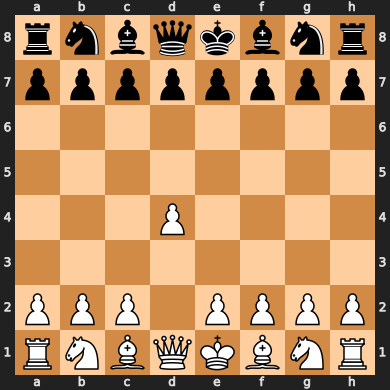

In [13]:
board = chess.Board('rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1')
board

In [4]:
stockfish = chess.engine.SimpleEngine.popen_uci(os.path.join('bin', 'stockfish_14_x64'))
engine = stockfish
# print(engine.options)
print(engine.id['name'])

Stockfish 14


In [17]:
analysis = engine.analyse(board, limit=chess.engine.Limit(depth=1))
move = analysis['pv'][0]
chess.square_name(move.from_square)

'g8'

In [67]:
match, suggestions = can_threat(board)
print(suggestions, len(suggestions))
for move in suggestions:
    analysis = engine.analyse(board, limit=chess.engine.Limit(depth=1), root_moves=[move])
    print(analysis)
engine.quit()

[Move.from_uci('b8c6'), Move.from_uci('c7c5'), Move.from_uci('e7e5')] 3
{'string': 'NNUE evaluation using nn-3475407dc199.nnue enabled', 'depth': 1, 'seldepth': 1, 'multipv': 1, 'score': PovScore(Cp(-89), BLACK), 'nodes': 1, 'nps': 1000, 'tbhits': 0, 'time': 0.001, 'pv': [Move.from_uci('b8c6')]}
{'string': 'NNUE evaluation using nn-3475407dc199.nnue enabled', 'depth': 1, 'seldepth': 1, 'multipv': 1, 'score': PovScore(Cp(-61), BLACK), 'nodes': 2, 'nps': 2000, 'tbhits': 0, 'time': 0.001, 'pv': [Move.from_uci('c7c5'), Move.from_uci('d4c5')]}
{'string': 'NNUE evaluation using nn-3475407dc199.nnue enabled', 'depth': 1, 'seldepth': 1, 'multipv': 1, 'score': PovScore(Cp(-205), BLACK), 'nodes': 2, 'nps': 2000, 'tbhits': 0, 'time': 0.001, 'pv': [Move.from_uci('e7e5'), Move.from_uci('d4e5')]}


In [ ]:
match, suggestions = skewer(board)
# print(match, suggestions)
top_moves = get_top_n_moves(engine, len(suggestions), board)
# print(top_moves)
if match:
    evals = get_evals(stockfish, board, suggestions)
    # print(board.fen(), match, list(zip(suggestions, evals)), top_moves)
print(evaluate(evals, top_moves))

In [ ]:
engine.quit()

# Building a dataset of positions + moves for use with Popper

In [5]:
def fen_to_contents(fen: str) -> str:
    "Convert a FEN position into a contents predicate"
    board = chess.Board()
    board.set_fen(fen)
    piece_str_list = []
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            color = 'white' if piece.color else 'black'
            piece_name = chess.piece_name(piece.piece_type)
            row = chess.square_rank(square) + 1
            col = chess.square_file(square) + 1
            piece_str_list.append(f'contents({color}, {piece_name}, {col}, {row})')
    return f'[{", ".join(piece_str_list)}]'

In [6]:
def write_example(examples_file, board, move):
    contents = fen_to_contents(board.fen())
    from_square = chess.square_name(move.from_square)
    to_square = chess.square_name(move.to_square)
    example_string = f'pos(f({contents}, {from_square}, {to_square})).\n'
    examples_file.write(example_string)

## Iterate over all positions in database

In [7]:
exs_written = 0
LIMIT = 1000

with open('ex.pl', 'a') as examples:
    for game in games(lichess_2013):
        if exs_written >= LIMIT:
            break
        node = game.next()
        while not node.is_end():
            if exs_written >= LIMIT:
                break
            board = node.board()
            analysis = engine.analyse(board, limit=chess.engine.Limit(depth=1))
            move = analysis['pv'][0]
            write_example(examples, board, move)
            exs_written += 1
            node = node.next()
